LangChain Expression Language (LCEL)

LangChain was designed from day 1 to support putting prototypes in production, with no code changes.
From the simplest “prompt + LLM” chain to the most complex chains (we’ve seen folks successfully run LCEL chains with 100s of steps in production). 

Streaming support
 
When you build your chains with LCEL you get the best possible time-to-first-token (time elapsed until the first chunk of output comes out)

Async support 

Any chain built with langchain can be called both with the synchronous API.

This enables using the same code for prototypes and in production, with great performance, and the ability to handle many concurrent requests in the same server.

Optimized parallel 

Execution whenever your langchain chains have steps that can be executed in parallel (eg if you fetch documents from multiple retrievers) we automatically do it, 

both in the sync and the async interfaces, for the smallest possible latency

Retries and fallbacks 

Configure retries and fallbacks for any part of your langchain chain. 

This is a great way to make your chains more reliable at scale. 

Access intermediate results 

For more complex chains it’s often very useful to access the results of intermediate steps even before the final output is produced. 

This can be used to let end-users know something is happening, or just to debug your chain. 

You can stream intermediate results, and it’s available on every LangServe server.

Input and output schemas 

Input and output schemas give every langchain chain Pydantic and JSONSchema schemas inferred from the structure of your chain. 

This can be used for validation of inputs and outputs, and is an integral part of LangServe.

Seamless LangSmith tracing integration 

As your chains get more and more complex, it becomes increasingly important to understand what exactly is happening at every step. 

With langchain, all steps are automatically logged to LangSmith for maximum observability and debuggability.

Seamless LangServe deployment integration 

Any chain created with langchain can be easily deployed using LangServe.

In [1]:
%pip install --upgrade --quiet  langchain-core langchain-community langchain-openai

Note: you may need to restart the kernel to use updated packages.


In [1]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI

prompt = ChatPromptTemplate.from_template("tell me a short joke about {topic}")
model = ChatOpenAI(model="gpt-4")
output_parser = StrOutputParser()

chain = prompt | model | output_parser

chain.invoke({"topic": "ice cream"})

# response = "Why don't ice creams ever get invited to parties?\n\nBecause they always melt under pressure!"
# The symbol  "|"  chains together the different components feeds the output from one component as input into the next component.


"Why don't ice creams ever get invited to parties?\n\nBecause they always melt under pressure!"

In [4]:
prompt_value = prompt.invoke({"topic": "ice cream"})
prompt_value

# ChatPromptValue(messages=[HumanMessage(content='tell me a short joke about ice cream')])

prompt_value.to_messages()
# [HumanMessage(content='tell me a short joke about ice cream')]

prompt_value.to_string()
#  'Human: tell me a short joke about ice cream'

'Human: tell me a short joke about ice cream'

In [5]:
message = model.invoke(prompt_value)
message

AIMessage(content="Why don't ice creams ever get invited to parties?\n\nBecause they always melt under pressure!", response_metadata={'finish_reason': 'stop', 'logprobs': None})

In [6]:
from langchain_openai.llms import OpenAI

llm = OpenAI(model="gpt-3.5-turbo-instruct")
llm.invoke(prompt_value) # '\n\n Why did the ice cream go to therapy?\n\n Because it was feeling a little rocky road.'

'\n\nWhy did the ice cream go to therapy?\n\nBecause it was feeling a little rocky road.'

In [7]:
# message = AIMessage(content="Why don't ice creams ever get invited to parties?\n\nBecause they always melt under pressure!", 
# response_metadata={'finish_reason': 'stop', 'logprobs': None})

output_parser.invoke(message)

"Why don't ice creams ever get invited to parties?\n\nBecause they always melt under pressure!"

## Pipeline

1 - Pass in user input as topic  {"topic": "ice cream"}


2 - The prompt component takes the user input, which is then used to construct a PromptValue after using the topic to construct the prompt.


3 - The model component takes the generated prompt, and passes into the OpenAI LLM model for evaluation. The generated output from the model is a ChatMessage object.


4 - Finally, the output_parser component takes in a ChatMessage, and transforms this into a Python string, which is returned from the invoke method.


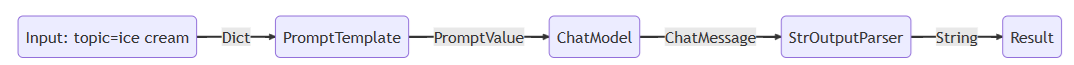

In [8]:
input = {"topic": "ice cream"}

prompt.invoke(input)
# > ChatPromptValue(messages=[HumanMessage(content='tell me a short joke about ice cream')])

model = ChatOpenAI(model="gpt-4")

(prompt | model).invoke(input)
# > AIMessage(content="Why did the ice cream go to therapy?\nBecause it had too many toppings and couldn't cone-trol itself!")

# AIMessage( content="Why don't ice creams ever get invited to parties? \n\n
# Because they always drip when they're too chilled!", response_metadata={'finish_reason': 'stop', 'logprobs': None})

AIMessage(content="Why don't ice creams ever get invited to parties? \n\nBecause they always drip when they're too chilled!", response_metadata={'finish_reason': 'stop', 'logprobs': None})

## RAG Search

retrieval-augmented generation chain to add some context when responding to questions.

In [9]:
%pip install langchain docarray tiktoken

Note: you may need to restart the kernel to use updated packages.


In [1]:
from langchain_community.vectorstores import DocArrayInMemorySearch
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnableParallel, RunnablePassthrough
from langchain_openai.chat_models import ChatOpenAI
from langchain_openai.embeddings import OpenAIEmbeddings

In [2]:
vectorstore = DocArrayInMemorySearch.from_texts(
    ["harrison worked at kensho", "bears like to eat honey"],
    embedding=OpenAIEmbeddings(),
)
retriever = vectorstore.as_retriever()

template = """Answer the question based only on the following context:
{context}

Question: {question}
"""
prompt = ChatPromptTemplate.from_template(template)
model = ChatOpenAI()
output_parser = StrOutputParser()

setup_and_retrieval = RunnableParallel(
    {"context": retriever, "question": RunnablePassthrough()}
)
chain = setup_and_retrieval | prompt | model | output_parser

chain.invoke("where did harrison work?")

# response = 'Harrison worked at Kensho.'

# WARNING:tensorflow:From C:\Users\btina\AppData\Roaming\Python\Python311\site-packages\keras\src\losses.py:2976: 
# The name   tf.          losses.sparse_softmax_cross_entropy is deprecated. 
# Please use tf.compat.v1.losses.sparse_softmax_cross_entropy instead.



'Harrison worked at Kensho.'

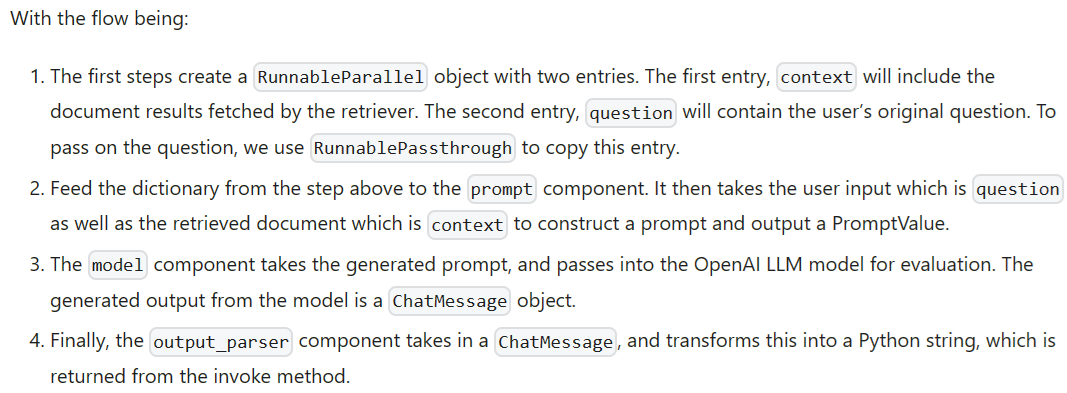

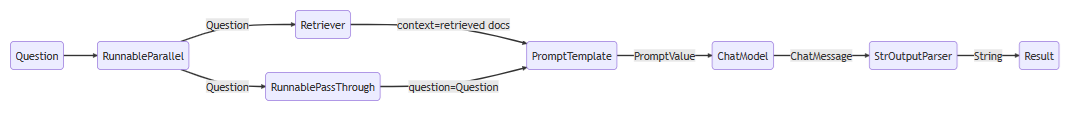

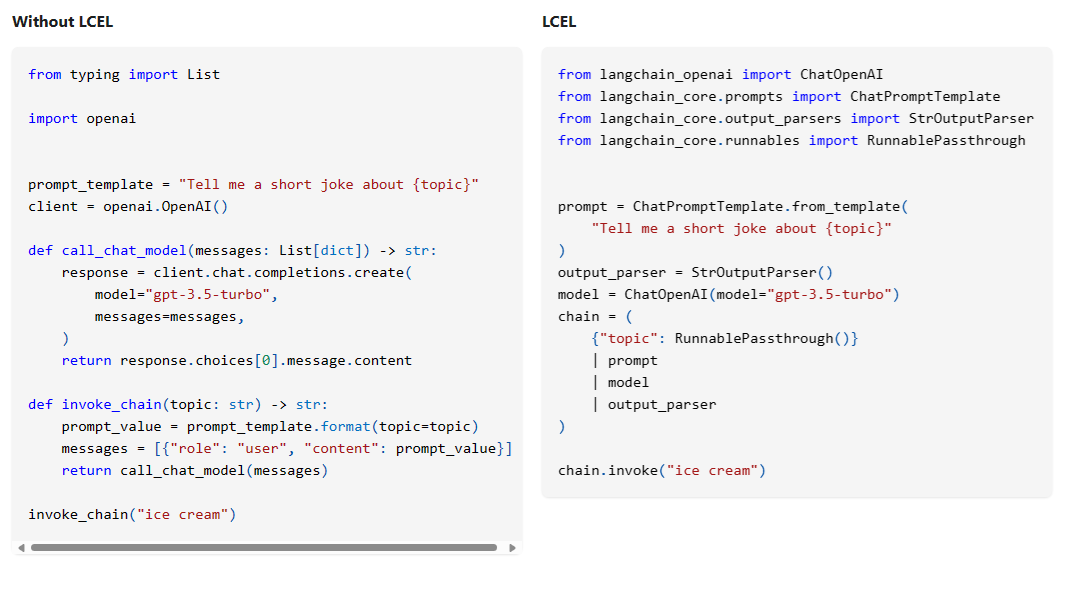

In [3]:
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough


prompt = ChatPromptTemplate.from_template(
    "Tell me a short joke about {topic}"
)
output_parser = StrOutputParser()
model = ChatOpenAI(model="gpt-3.5-turbo")
chain = (
    {"topic": RunnablePassthrough()} 
    | prompt
    | model
    | output_parser
)

chain.invoke("ice cream")

# response = 'Why did the ice cream truck break down? Because it had too many "scoops" on board!'

'Why did the ice cream truck break down? Because it had too many "scoops" on board!'

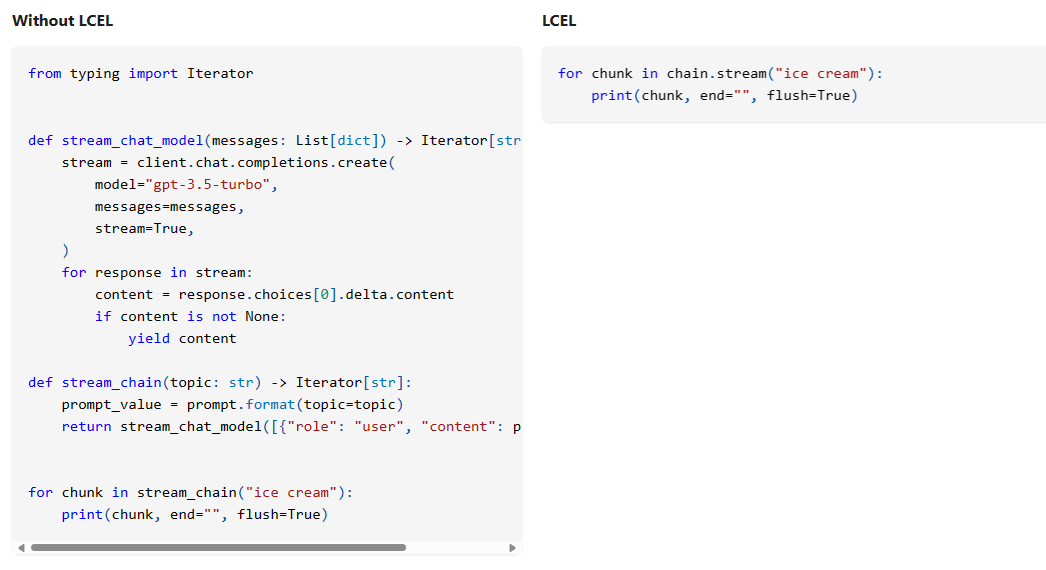

In [4]:
for chunk in chain.stream("ice cream"):
    print(chunk, end="", flush=True)

# Why did the ice cream truck break down?
# Because it had too many "scoops" of ice cream!   

Why did the ice cream truck break down?
Because it had too many "scoops" of ice cream!